### A simple time series model
In this notebook different block response functions are introduced. The time series are convoluted with these response functions to calculate the contribution of that stress to the head.

In [1]:
from gwtsa import * # Import the GWTSA package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Make sure plot made in this notebook are displayed in the notebook.
%matplotlib inline

### Import observed time series
In this section the observed time series are imported. In this exaple these are the groundwater levels observed in a well in The Netherlands (ID B58C0698001). The following characteristics are important when importing and preparing the observed time series:
- The observed time series are stored as a Pandas time series object
- All lines must contain a value, nan must be dropped
- The time step can be irregular, this is no problem for `gwtsa`

The observed series are stored as: <class 'pandas.core.series.Series'>


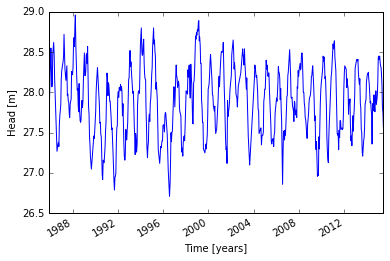

In [2]:
# Import and check the imported groundwater level time series
gwdata = pd.read_csv('B58C0698001_0.csv', skiprows=11,
                     parse_dates=['PEIL DATUM TIJD'],
                     index_col='PEIL DATUM TIJD',
                     skipinitialspace=True)
gwdata.rename(columns={'STAND (MV)': 'h'}, inplace=True)
gwdata.index.names = ['date']
gwdata.h *= 0.01  # Make unit meters
oseries = 30.17 - gwdata.h  # NAP
oseries.dropna(inplace=True)
print 'The observed series are stored as:', type(oseries) # Check the data type

# Plot the observed time series
oseries.plot();
plt.ylabel('Head [m]');
plt.xlabel('Time [years]');

### Import stresses
In this section the stresses are imported. Important characteristics of these time series:
- Same units as the observed time series
- Values are necessary on every time step
- The time series should be stored as Pandas Time Series

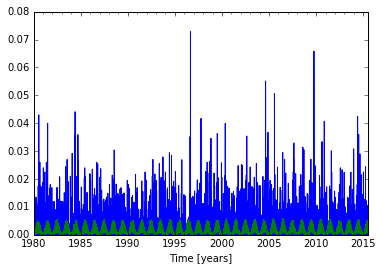

In [3]:
#Import and check the precipitation data
rain = pd.read_csv('Heibloem_rain_data.dat', skiprows=4, delim_whitespace=True,
                   parse_dates=['date'],
                   index_col='date')
rain = rain['1980':]  # cut off everything before 1980
rain = rain.precip
rain *=0.001
rain.fillna(rain.mean(), inplace=True)

# Import and check the evaporation data
evap = pd.read_csv('Maastricht_E_June2015.csv', skiprows=4, sep=';',
                   parse_dates=['DATE'],
                   index_col='DATE')
evap.rename(columns={'VALUE (m-ref)':'evap'}, inplace=True)
evap = evap['1980':]  # cut off everything before 1980
evap = evap.evap
evap.fillna(evap.mean(), inplace=True)

# Plot the time series of the precipitation and evaporation
rain.plot(label='precipitation')
evap.plot(label='evaporation')
plt.xlabel('Time [years]')

### Model setup
In this section the model is setup. a `tseries` object is created for each time series.

The time series model created below consists of the following components:
- A linear recharge model (`Tseries2`) convoluted with an exponential decay function (`ExpDecay`).
- A constant d, the base elevation of the model
- A NoiseModel (exponential error model)




In [5]:
ml = Model(oseries) # Create a model
ts1 = Tseries2(rain, evap, Exponential(), name='recharge')
ml.addtseries(ts1)
d = Constant()
ml.addtseries(d)
n = NoiseModel()
ml.addnoisemodel(n)

### Solving the model
In this section the model is solved.


In [6]:
ml.solve()

[[Fit Statistics]]
    # function evals   = 45
    # data points      = 644
    # variables        = 5
    chi-square         = 4.062
    reduced chi-square = 0.006
[[Variables]]
    recharge_A:    681.249643 +/- 35.95233 (5.28%) (init= 500)
    recharge_a:    154.481366 +/- 8.160787 (5.28%) (init= 100)
    recharge_f:   -1.28707925 +/- 0.051432 (4.00%) (init=-1)
    constant_d:    27.8998426 +/- 0.057054 (0.20%) (init= 0)
    noise_alpha:   51.4798960 +/- 6.696503 (13.01%) (init= 14)
[[Correlations]] (unreported correlations are <  0.100)
    C(recharge_f, constant_d)    = -0.981 
    C(recharge_A, recharge_a)    =  0.824 
    C(recharge_A, recharge_f)    =  0.561 
    C(recharge_A, constant_d)    = -0.543 
    C(recharge_a, recharge_f)    =  0.132 
    C(recharge_a, constant_d)    = -0.120 


### Plotting the results


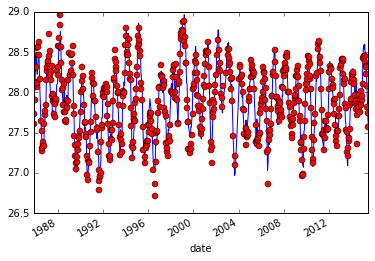

In [7]:
ml.plot()

### Plotting more information on the time series model
Often a simple plot of the simulated and observed series does not give enough informaion. To obtain more information on the calibrated model the command `plot_results` provides a plot with more information. 

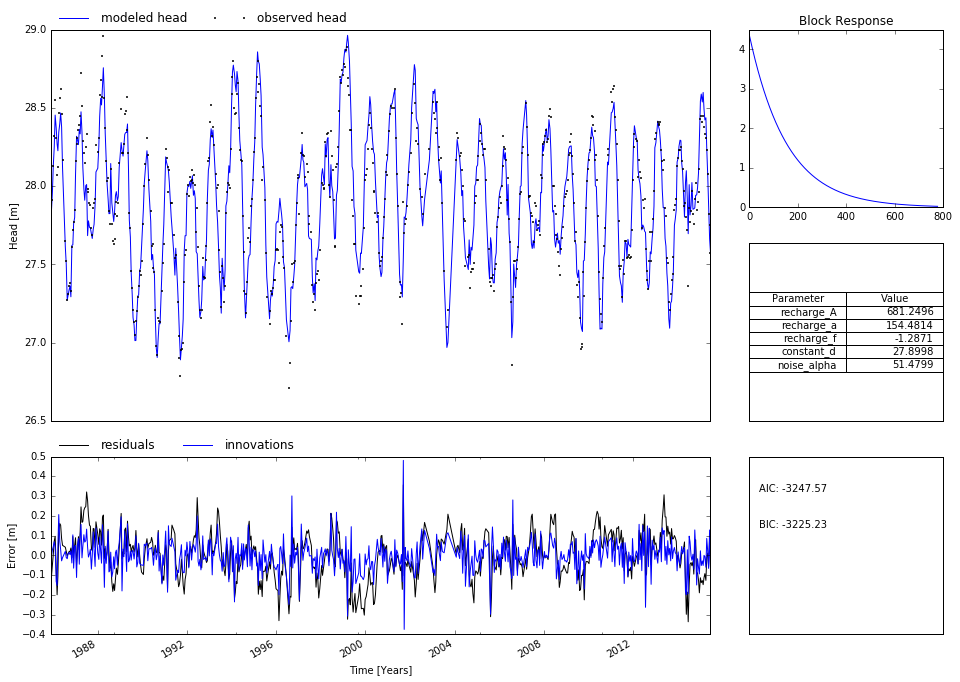

In [8]:
ml.plot_results()